In [1]:
import os
import torch
import torch.nn as nn
import torch.distributions as td
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import trange 
import random
from torch.utils.data import DataLoader, TensorDataset
from models import RealNVP
from models import AutoEncoderA, AutoEncoderC, AutoEncoderA2, AutoencoderA3, AutoEncoderB
from ae_and_flow import AutoEncoder
from sklearn.model_selection import train_test_split
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import gc
import pandas as pd
from PIL import Image

device = torch.device("cuda")

data_dir = "/scratch/s/S.Liu/sbi_lab/data/"
figs_dir = "/scratch/s/S.Liu/sbi_lab/figs/grfs/" # Change this to your specification

for _path in [data_dir, figs_dir]:
    if not os.path.exists(_path):
        os.makedirs(_path, exist_ok=True)

In [2]:
"""
    Fit NVP flow to GRFs at the field level (likelihood).
"""

def convert(x):
    return torch.as_tensor(x).float()


def get_dataloader_from_arrays(data, targets, batch_size):

    class TensorDataset(Dataset):
        def __init__(self, data, targets):
            self.data = torch.as_tensor(data).float()
            self.labels = torch.as_tensor(targets).float()
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, idx):
            sample = self.data[idx]
            label = self.labels[idx]
            return sample, label

    # Create dataset and dataLoader
    dataset = TensorDataset(data, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def looploader(dataloader):
    while True:
        for x in iter(dataloader): 
            yield x

            # Model / inference stuff
AB = np.array([1., 2.5]) # Fiducial cosmology
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
parameter_names = ["A", "B"]
# Data
n_pix = 32
data_shape = (n_pix, n_pix)
data_dim = np.prod(data_shape)
parameter_dim = len(AB)


# Load data 
D = np.load(os.path.join(data_dir, f"grfsL_{n_pix=}.npy"))
D_ = np.load(os.path.join(data_dir, f"dataL_{n_pix=}.npy"))
Y = np.load(os.path.join(data_dir, f"grfsL_parameters_{n_pix=}.npy"))

# Add image channels for convolutions
n_use = 5000
D = convert(D[:n_use, None, ...])
D_ = convert(D_[None, None, ...]) # Single batch axis for single measurement
Y = convert(Y[:n_use])

# D, Y = D[:100], Y[:100]

# # D = np.stack([D[0]] * 10)
# # Y = np.stack([Y[0]] * 10)

# print(f"Simulations: {D.shape=} {Y.shape=}, Data {D_.shape}")

D = 2. * (D - D.min()) / (D.max() - D.min()) - 1.

# # Plot some training samples for comparison
# fig, axs = plt.subplots(1, 4, dpi=200)
# for i, ax in enumerate(axs):
#     A, B = Y[i]
#     ax.set_title(f"{A=:.1f}, {B=:.1f}")
#     im = ax.imshow(D[i].squeeze(), cmap="bwr")
#     ax.axis("off")
# plt.tight_layout()
# plt.savefig(os.path.join(figs_dir, "train_samples.png"))
# plt.show()
            

In [8]:
# Load data 
D = np.load(os.path.join(data_dir, f"grfsL_{n_pix=}.npy"))
D_ = np.load(os.path.join(data_dir, f"dataL_{n_pix=}.npy"))
Y = np.load(os.path.join(data_dir, f"grfsL_parameters_{n_pix=}.npy"))

# Add image channels for convolutions
n_use = 100000
D = convert(D[:n_use, None, ...])
D_ = convert(D_[None, None, ...]) # Single batch axis for single measurement
Y = convert(Y[:n_use])
D = 2. * (D - D.min()) / (D.max() - D.min()) - 1.

In [4]:
#define the model class
class AutoEncoder(nn.Module):
    def __init__(self, ksize=[3,3,3,3,3,3], knum=[256,512,1024],
                 kstride=[2,2,2,2,2,2], Cdroprate=[0.2,0.2,0.2,0.2,0.2,0.2],Ctdroprate=[0.,0.2,0.2,0.2,0.2,0.2],
                  Ddroprate=[0.2,0.2,0.2,0.2,0.2,0.2],Dtdroprate=[0.,0.2,0.2,0.2,0.2,0.2],z_drop=0.2, activ=nn.Tanh(),
                 padding=1,input_shape=[1,32,32],Dsize=[128,64,32],z_dim=8,bias=True):
        '''

        '''
        super(AutoEncoder, self).__init__()
        
        self.activ = activ
        self.input_shape=input_shape
        self.z_dim=z_dim
        self.z_drop=z_drop
        self.hidden=knum[-1]

        # Create convolutional and pooling layers
        self.CDP_layers = nn.ModuleList()
        self.CDPt_layers = nn.ModuleList()
        Cnum = len(knum)
        Dnum = len(Dsize)
        ksize=ksize[:Cnum]
        kstride=kstride[:Cnum]
        Cdroprate=Cdroprate[:Cnum]
        Ctdroprate=Ctdroprate[:Cnum]
        Ddroprate=Ddroprate[:Dnum]
        Dtdroprate=Dtdroprate[:Dnum]
        if z_drop!=0.:
            Ctdroprate[0]=0.
        for i in range(Cnum):
            self.CDP_layers.append(nn.Conv2d(self.input_shape[0] if i == 0 else knum[i-1], knum[i], kernel_size=ksize[i], stride=kstride[i], padding=padding,bias=bias))
            self.CDP_layers.append(nn.Dropout(Cdroprate[i],inplace=False))
            self.CDP_layers.append(self.activ)

            # if psize[i] is not None:
            #     if ptype == 'max':
            #         self.CDP_layers.append(nn.MaxPool2d(kernel_size=psize[i], stride=pstride[i],padding=ppadding))
            #     else:
            #         self.pool_layers.append(nn.AvgPool2d(kernel_size=psize[i], stride=pstride[i],padding=ppadding))
        for i in range(Cnum):
            self.CDPt_layers.append(nn.ConvTranspose2d(knum[Cnum-i-1], self.input_shape[0] if i == Cnum-1 else knum[Cnum-i-2], kernel_size=ksize[Cnum-i-1], stride=kstride[Cnum-i-1],padding=padding,output_padding=1))
            self.CDPt_layers.append(nn.Dropout(Ctdroprate[Cnum-i-1],inplace=False))
            self.CDPt_layers.append(self.activ)            
            

        self.Dlayers = nn.ModuleList()
        self.Dtlayers = nn.ModuleList()
        self.out_dim,self.out_n_pix = self._get_flattened_size()
        in_features=self.out_dim
        
        for i in range(Dnum):
            D=Dsize[i]
            self.Dlayers.append(nn.Linear(in_features, D))
            self.Dlayers.append(nn.Dropout(p=Ddroprate[i]))            
            self.Dlayers.append(self.activ)            
            in_features = D
        self.outD=nn.Linear(in_features,self.z_dim)
        self.inD=nn.Linear(self.z_dim,in_features)
        for i in range(len(Dsize)):
            D=Dsize[Dnum-i-2] if i!=Dnum-1 else self.out_dim
            self.Dtlayers.append(nn.Linear(in_features,D))
            self.Dtlayers.append(nn.Dropout(p=Dtdroprate[Dnum-i-1]))            
            self.Dtlayers.append(self.activ)                    
            in_features = D
        self.flatten = nn.Flatten()


    def _get_flattened_size(self):
        # Determine the size after flattening
        with torch.no_grad():
            x = torch.zeros(self.input_shape)
            for CDPlayer in self.CDP_layers:
                x=CDPlayer(x)
            return x.numel(),x.shape[1]

    def encoder(self,x):
        for CDPlayer in self.CDP_layers:
            x=CDPlayer(x)
        x=self.flatten(x)
        for Dlayer in self.Dlayers:
            x = Dlayer(x)
        z=self.outD(x)
        return z
    def decoder(self,z):
        _x=(self.inD(z))
        _x=self.activ(nn.Dropout(p=self.z_drop)(_x))
        for Dlayer in self.Dtlayers:
            _x=Dlayer(_x)
        _x = _x.view(-1, self.hidden, self.out_n_pix, self.out_n_pix)
        for CDPtlayer in self.CDPt_layers:
            _x=CDPtlayer(_x)
        return _x
    def forward(self,x):
        z=self.encoder(x)
        _x=self.decoder(z)
        return _x,z

Epoch 1, Train Loss: 0.01635211, Validation Loss: 0.01505036, LR: 1.000e-04
Epoch 2, Train Loss: 0.01587091, Validation Loss: 0.01466445, LR: 1.000e-04
Epoch 3, Train Loss: 0.01546569, Validation Loss: 0.01433565, LR: 1.000e-04
Epoch 4, Train Loss: 0.01510437, Validation Loss: 0.01403773, LR: 1.000e-04
Epoch 5, Train Loss: 0.01477255, Validation Loss: 0.01377227, LR: 1.000e-04
Epoch 6, Train Loss: 0.01449320, Validation Loss: 0.01352732, LR: 1.000e-04
Epoch 7, Train Loss: 0.01421894, Validation Loss: 0.01330416, LR: 1.000e-04
Epoch 8, Train Loss: 0.01399434, Validation Loss: 0.01310836, LR: 1.000e-04
Epoch 9, Train Loss: 0.01377539, Validation Loss: 0.01294806, LR: 1.000e-04
Epoch 10, Train Loss: 0.01356456, Validation Loss: 0.01278553, LR: 1.000e-04
Epoch 11, Train Loss: 0.01339412, Validation Loss: 0.01263656, LR: 1.000e-04
Epoch 12, Train Loss: 0.01326113, Validation Loss: 0.01251226, LR: 1.000e-04
Epoch 13, Train Loss: 0.01311538, Validation Loss: 0.01240107, LR: 1.000e-04
Epoch 14

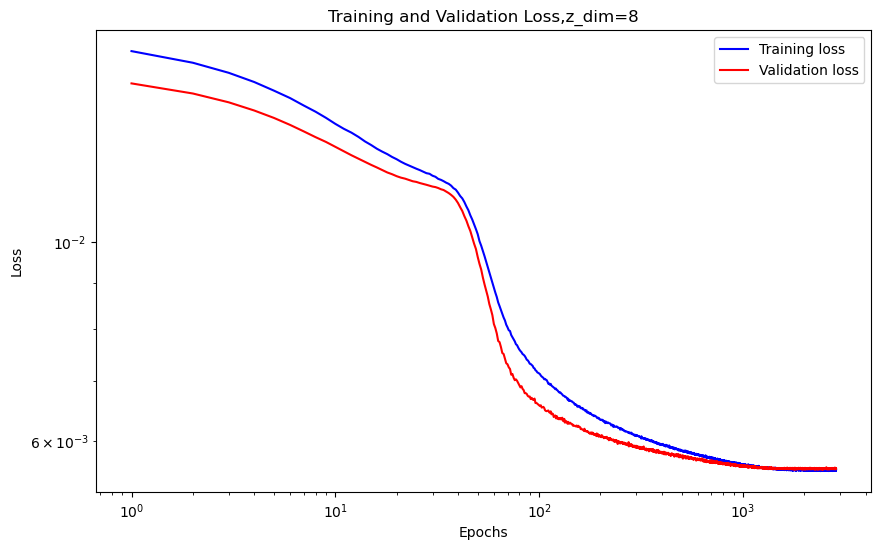

val_loss:0.005588310305029154
tr_loss:0.005456291371956468
test_loss:0.0051307412795722485


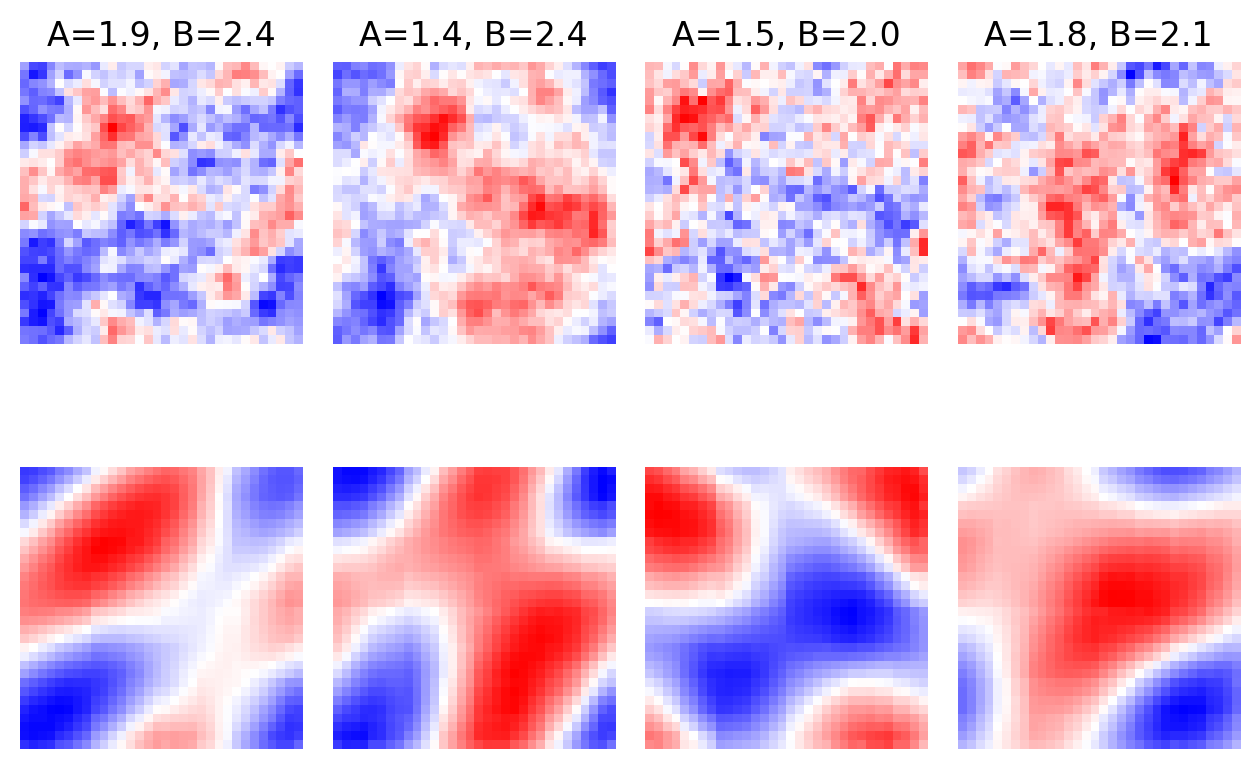

Epoch 1, Train Loss: 0.01551525, Validation Loss: 0.01456074, LR: 1.000e-04
Epoch 2, Train Loss: 0.01512151, Validation Loss: 0.01424113, LR: 1.000e-04
Epoch 3, Train Loss: 0.01479493, Validation Loss: 0.01396253, LR: 1.000e-04
Epoch 4, Train Loss: 0.01449121, Validation Loss: 0.01372181, LR: 1.000e-04
Epoch 5, Train Loss: 0.01424437, Validation Loss: 0.01349456, LR: 1.000e-04
Epoch 6, Train Loss: 0.01400287, Validation Loss: 0.01329427, LR: 1.000e-04
Epoch 7, Train Loss: 0.01377500, Validation Loss: 0.01310162, LR: 1.000e-04
Epoch 8, Train Loss: 0.01358559, Validation Loss: 0.01293522, LR: 1.000e-04
Epoch 9, Train Loss: 0.01339163, Validation Loss: 0.01277911, LR: 1.000e-04
Epoch 10, Train Loss: 0.01320964, Validation Loss: 0.01264584, LR: 1.000e-04
Epoch 11, Train Loss: 0.01306714, Validation Loss: 0.01250343, LR: 1.000e-04
Epoch 12, Train Loss: 0.01290892, Validation Loss: 0.01237612, LR: 1.000e-04
Epoch 13, Train Loss: 0.01279683, Validation Loss: 0.01227249, LR: 1.000e-04
Epoch 14

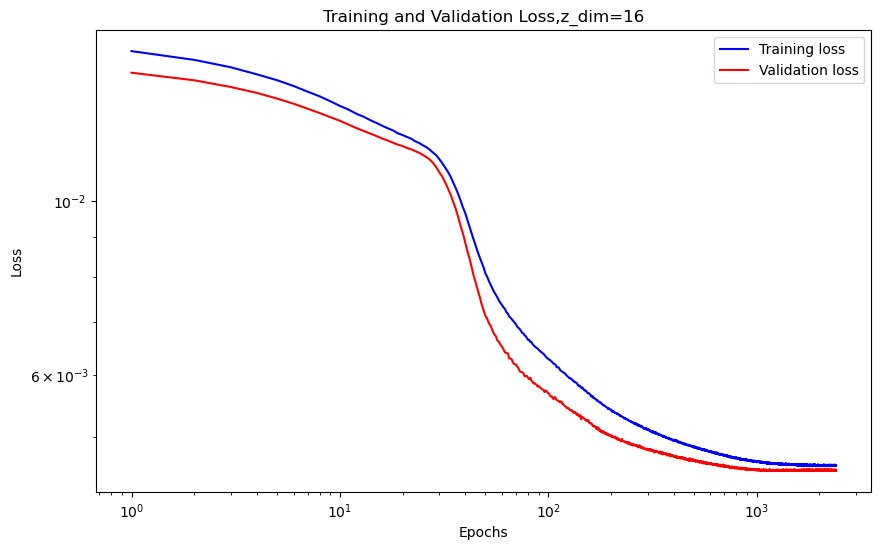

val_loss:0.004534399136900902
tr_loss:0.00441296654753387
test_loss:0.004201594740152359


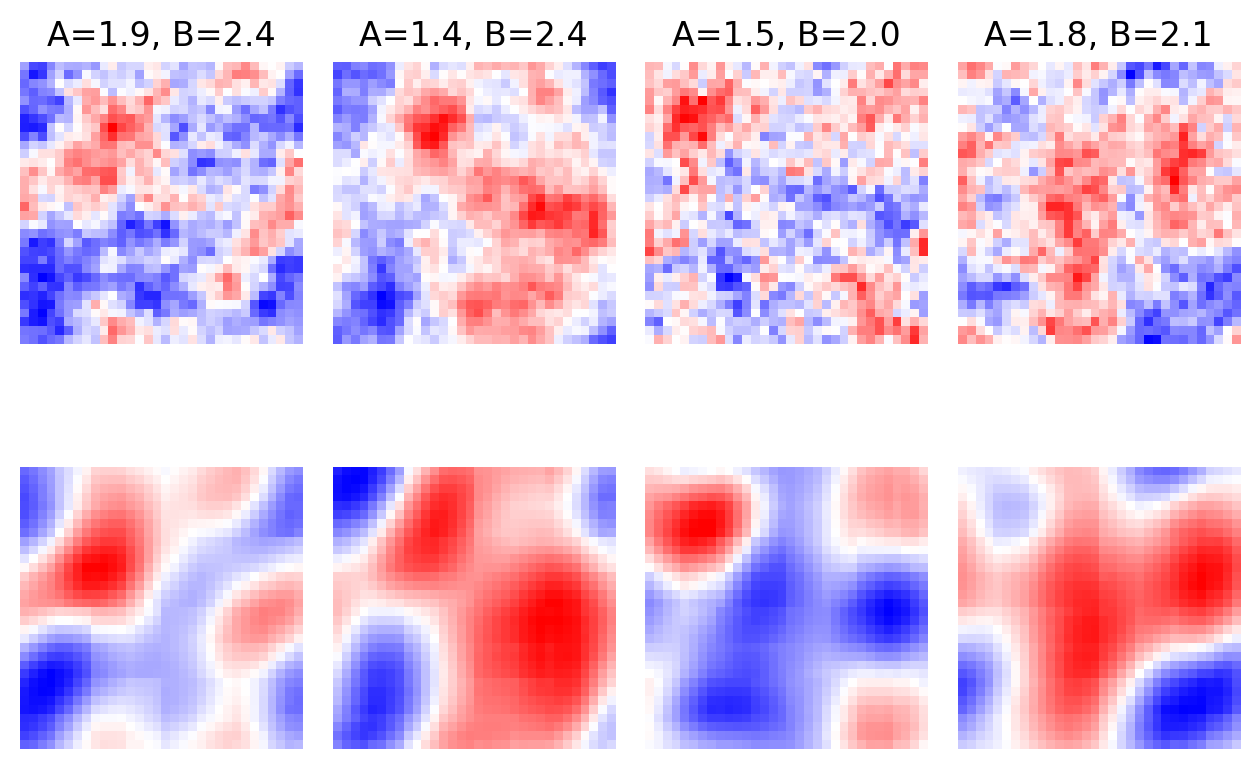

Epoch 1, Train Loss: 0.13184085, Validation Loss: 0.12635337, LR: 1.000e-04
Epoch 2, Train Loss: 0.12381909, Validation Loss: 0.11776434, LR: 1.000e-04
Epoch 3, Train Loss: 0.11515686, Validation Loss: 0.10752045, LR: 1.000e-04
Epoch 4, Train Loss: 0.10497047, Validation Loss: 0.09464820, LR: 1.000e-04
Epoch 5, Train Loss: 0.09287002, Validation Loss: 0.07922296, LR: 1.000e-04
Epoch 6, Train Loss: 0.07950008, Validation Loss: 0.06341662, LR: 1.000e-04
Epoch 7, Train Loss: 0.06698847, Validation Loss: 0.05100303, LR: 1.000e-04
Epoch 8, Train Loss: 0.05708221, Validation Loss: 0.04255874, LR: 1.000e-04
Epoch 9, Train Loss: 0.04962982, Validation Loss: 0.03611664, LR: 1.000e-04
Epoch 10, Train Loss: 0.04322841, Validation Loss: 0.03082996, LR: 1.000e-04
Epoch 11, Train Loss: 0.03828038, Validation Loss: 0.02722810, LR: 1.000e-04
Epoch 12, Train Loss: 0.03464101, Validation Loss: 0.02417230, LR: 1.000e-04
Epoch 13, Train Loss: 0.03183286, Validation Loss: 0.02179482, LR: 1.000e-04
Epoch 14

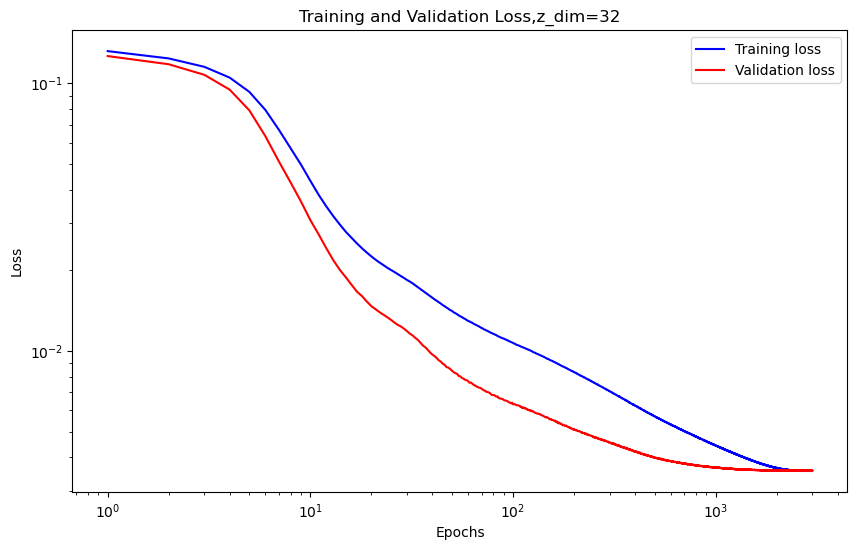

val_loss:0.0035657871048897505
tr_loss:0.0034329325426369905
test_loss:0.0033093516249209642


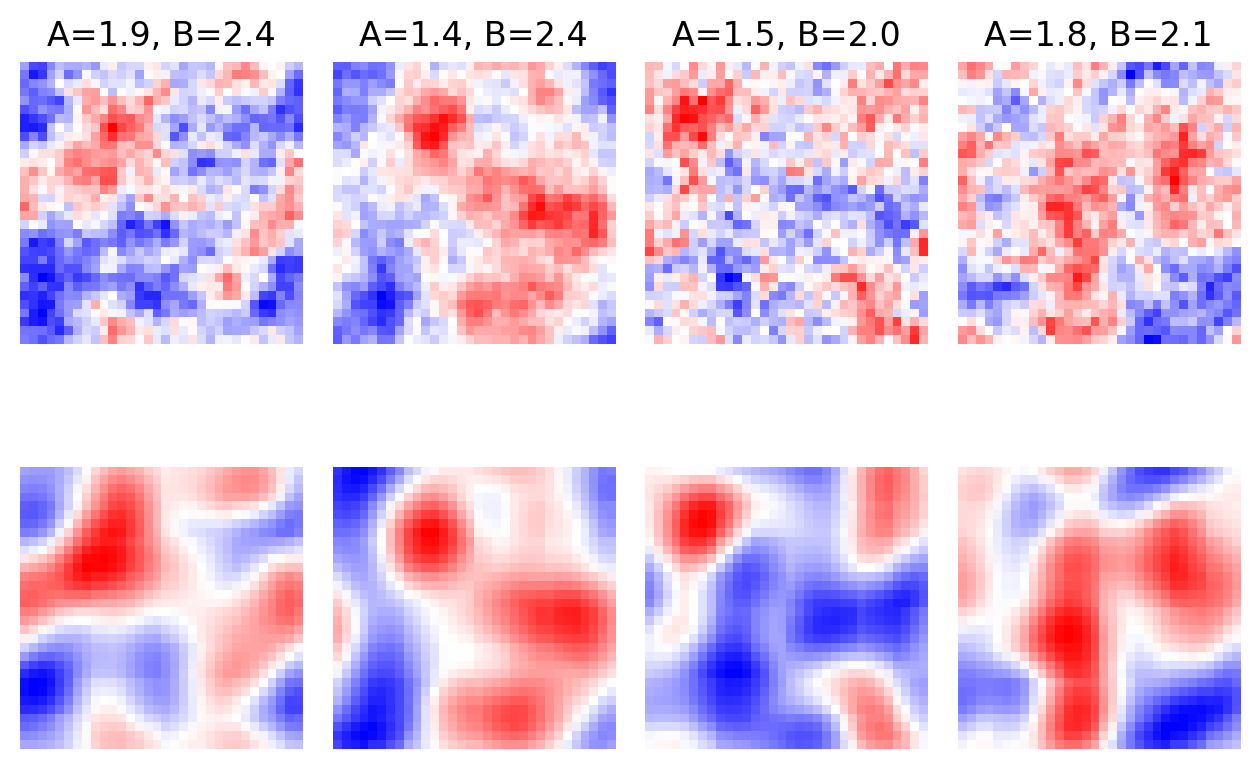

In [6]:
#hyperparameter scan, train the model, save the model and training results
seed=42
lr=1e-3
weight_decay=1e-5
patience_lr=300#300
factor=0.5#0.5
epochs=3000
batch_size=1024
patience=600
count=0
knums=[[16,32,64]]
Dsizes=[[]]#,
z_dims=[8,16,32]#[16,32,64
lrs=[1e-4]
tr_num=4000
val_num=500
te_num=500
for knum in knums:
    for Dsize in Dsizes:
        # if knum==[512,1024,2048] and Dsize not in [[32],[64]]:
        #     continue
        hyperparameterss=[]
        best_results=[]
        tr_historys,val_historys=[],[]
        for z_dim in z_dims:
            if z_dim==32:
                knum=[32,64,128]
            for lr in lrs:
                lr=lr
                gc.collect()
                torch.cuda.empty_cache()
                if seed!=None:
                    np.random.seed(seed)
                    random.seed(seed)
                    torch.manual_seed(seed)
                    torch.cuda.manual_seed(seed)
                    torch.cuda.manual_seed_all(seed)

                train_dataset = TensorDataset(D[:tr_num],D[:tr_num])
                val_dataset = TensorDataset(D[tr_num:tr_num+val_num],D[tr_num:tr_num+val_num])
                test_dataset = TensorDataset(D[tr_num+val_num:tr_num+val_num+te_num],D[tr_num+val_num:tr_num+val_num+te_num])
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

                loss_f = lambda _x, x: torch.square(torch.subtract(_x, x)).mean() 
                # Hidden dimension (~number of parameters in autoencoder model)
                hidden_dim = 1024 
                # z_dim=8
                data_shape=(n_pix,n_pix)
                # Build the autoencoder
                autoencoder = AutoEncoder(
                    knum=knum,
                    z_dim=z_dim, 
                   Dsize=Dsize
                )
                autoencoder = autoencoder.to(device)

                best_model = copy.deepcopy(autoencoder)
                optimizer = optim.Adam(autoencoder.parameters(),lr=lr,weight_decay=weight_decay)

                if isinstance(patience_lr, list):
                    scheduler=get_piecewise_scheduler(optimizer,patience_lr,factor)
                else:
                    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=factor,patience=patience_lr)


                losses = []

                # Training loop with early stopping and learning rate scheduling
                best_loss = float('inf')
                best_tr_loss= float('inf')
                epochs_no_improve = 0

                global_train_loss = []
                global_val_loss = []

                #begin truaining
                for epoch in range(epochs):
                    autoencoder.train()
                    train_loss = 0
                    for xtrb, ytrb in train_loader:
                        xtrb = xtrb.to(device)
                        ytrb=ytrb.to(device)
                        _x, emb = autoencoder(xtrb)
                        # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                        rec_loss = loss_f(_x, xtrb)

                        optimizer.zero_grad()
                        rec_loss.backward()
                        optimizer.step()
                        train_loss += rec_loss.item()

                    train_loss /= len(train_loader)
                    global_train_loss.append(train_loss)

                    autoencoder.eval()
                    val_loss = 0
                    with torch.no_grad():
                        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                        for xvalb,yvalb in val_loader:
                            xvalb = xvalb.to(device)
                            yvalb = yvalb.to(device)
                            _x, emb = autoencoder(xvalb)
                        # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                            rec_loss = loss_f(_x, xvalb)
                            val_loss += rec_loss.item()

                        val_loss /= len(val_loader)
                        if isinstance(patience_lr,list):
                            scheduler.step(epoch)
                        else:
                            scheduler.step(val_loss)
                            lr_ = optimizer.param_groups[0]['lr']
                            global_val_loss.append(val_loss)
                        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {lr_:.3e}")

                        # Early stopping and learning rate scheduling
                        if val_loss < best_loss:
                            best_loss = val_loss
                            best_model = autoencoder
                        # evalu_tc(best_model,val_loader,m_mean.numpy().astype('float32'),1.,filename=None)
                            epochs_no_improve = 0
                        elif train_loss>best_tr_loss+0.15:
                            epochs_no_improve = 0
                        else:
                            epochs_no_improve += 1
                            best_tr_loss=train_loss
                        if epochs_no_improve >= patience and epoch>=35:
                            print("Early stopping triggered")
                            break


                tr_losses,val_losses=global_train_loss,global_val_loss

                #compute the index coresponding to the best validation loss and validation metric
                min_index=val_losses.index(min(val_losses))

                best_result=[tr_losses[min_index],val_losses[min_index],sum(p.numel() for p in best_model.parameters())]
                param_names = ['knum','z_dim','Dsize','lr']

                hyperparameters=[knum,z_dim,Dsize,lr]
                hyperparameters = dict(zip(param_names, hyperparameters))
                print('hypeparameters: ', hyperparameters)
                print('best results:',best_result)
                hyperparameterss.append(hyperparameters)
                best_results.append(best_result)
                tr_historys.append(tr_losses)
                val_historys.append(val_losses)

                total_epoch = range(1, len(tr_losses) + 1)
                plt.figure(figsize=(10, 6))
                plt.loglog(total_epoch , tr_losses, 'b', label='Training loss')
                plt.loglog(total_epoch , val_losses, 'r', label='Validation loss')
                plt.title(f'Training and Validation Loss,z_dim={z_dim}')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                # plt.ylim([-2.,+1.])
                plt.legend()
                os.chdir('/home/s/S.Liu/grf_lab/lab-report/data_and_images')
                plt.savefig(f"loss_ae5000_{z_dim}.png")
                plt.show()
                torch.save(best_model,os.path.join(data_dir, f"ae5000_{z_dim}_{count}.pth"))
                autoencoder=torch.load(os.path.join(data_dir, f"ae5000_{z_dim}_{count}.pth"))
                autoencoder.eval()
                val_loss = 0
                with torch.no_grad():
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    for xvalb,yvalb in val_loader:
                        xvalb = xvalb.to(device)
                        yvalb = yvalb.to(device)
                        _x, emb = autoencoder(xvalb)
                    # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                        rec_loss = loss_f(_x, xvalb)
                        val_loss += rec_loss.item()

                    val_loss /= len(val_loader)     
                    print(f'val_loss:{val_loss}')
                    tr_loss=0.
                    for xvalb,yvalb in train_loader:
                        xvalb = xvalb.to(device)
                        yvalb = yvalb.to(device)
                        _x, emb = autoencoder(xvalb)
                    # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                        rec_loss = loss_f(_x, xvalb)
                        tr_loss += rec_loss.item()

                    tr_loss /= len(train_loader)  
                    print(f'tr_loss:{tr_loss}')
                    te_loss=0.
                    for xvalb,yvalb in test_loader:
                        xvalb = xvalb.to(device)
                        yvalb = yvalb.to(device)
                        _x, emb = autoencoder(xvalb)
                    # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                        rec_loss = loss_f(_x, xvalb)
                        te_loss += rec_loss.item()

                    te_loss /= len(test_loader)  
                    print(f'test_loss:{te_loss}')     
                    with torch.no_grad():
                        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

                        xvalb = D[4500:4510].to(device)
                        _x, emb = autoencoder(xvalb)
                        xvalb,_x=xvalb.cpu().detach().numpy(),_x.cpu().detach().numpy(),

                        fig, axs = plt.subplots(2, 4, dpi=200)
                        for i, ax in enumerate(axs[0, :]):
                            A, B = Y[3500+i]
                            ax.set_title(f"{A=:.1f}, {B=:.1f}")
                            im = ax.imshow(xvalb[i].reshape(data_shape), cmap="bwr")
                            ax.axis("off")
                        for i, ax in enumerate(axs[1, :]):
                            im = ax.imshow(_x[i].reshape(data_shape), cmap="bwr")
                            ax.axis("off")
                        plt.tight_layout()
                        plt.savefig(os.path.join(figs_dir, f"autoencoder_reconstructions5000_{z_dim}.png"))
                        plt.show()
                gc.collect()
                torch.cuda.empty_cache()
                
        # with open(f'Auto2_hyper_{count}.pickle','wb') as f:
        #     pickle.dump(hyperparameterss,f)
        # with open(f'Auto2_best_{count}.pickle','wb') as f:
        #     pickle.dump(best_results,f)
        # with open(f'Auto2_tr_{count}.pickle','wb') as f:
        #     pickle.dump(tr_historys,f)
        # with open(f'Auto2_val_{count}.pickle','wb') as f:
        #     pickle.dump(val_historys,f)
        # count+=1

In [9]:
#calculate the MSE loss of trained model in 100000 new generated graphs
loss_f = lambda _x, x: torch.square(torch.subtract(_x, x)).mean() 
train_dataset = TensorDataset(D[:100000],D[:100000])
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=False)
for z_dim in [8,16,32]:
    autoencoder=torch.load(os.path.join(data_dir, f"ae5000_{z_dim}.pth"))
    autoencoder.eval()
    embs=torch.Tensor([]).to('cpu')
    with torch.no_grad():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        for xvalb,yvalb in train_loader:
            xvalb = xvalb.to(device)
            yvalb = yvalb.to(device)
            _x, emb = autoencoder(xvalb)
            embs=torch.cat((embs,emb.to('cpu')))
        val_dataset = TensorDataset(embs[:100000],D[:100000])
        val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)
        val_loss=0.
        for xvalb,yvalb in val_loader:
            xvalb = xvalb.to(device)
            yvalb = yvalb.to(device)
            _x= autoencoder.decoder(xvalb)
            rec_loss = loss_f(_x, yvalb)
            val_loss += rec_loss.item()

        val_loss /= len(val_loader)     
        print(f'val_loss:{val_loss}')
    np.save(os.path.join(data_dir, f"AEL_{z_dim}.npy"), embs.detach().numpy())

val_loss:0.004503202638588845
val_loss:0.0036897955229505896
val_loss:0.0028806239215191454


In [ ]:
#collect the training results and merge them 
counts=range(67,103)
h,b=[],[]
for count in counts:
    with open(f'Auto2_hyper_{count}.pickle','rb') as f:
        h.extend(copy.deepcopy(pickle.load(f)))
    with open(f'Auto2_best_{count}.pickle','rb') as f:
        b.extend(copy.deepcopy(pickle.load(f)))
counts=range(1,65)
for count in counts:
    with open(f'Auto2_hyper_{count}.pickle','rb') as f:
        h.extend(copy.deepcopy(pickle.load(f)))
    with open(f'Auto2_best_{count}.pickle','rb') as f:
        b.extend(copy.deepcopy(pickle.load(f)))
with open(f'Auto2_hyper.pickle','wb') as f:
    pickle.dump(h,f)
with open(f'Auto2_best.pickle','wb') as f:
    pickle.dump(b,f)
h,b=[],[]
with open(f'Auto2_hyper.pickle','rb') as f:
    h.extend(copy.deepcopy(pickle.load(f)))
with open(f'Auto2_best.pickle','rb') as f:
    b.extend(copy.deepcopy(pickle.load(f)))

In [4]:
#find the optimal hyperparameter setting and results
b2=np.array(b).T[1]
indices=np.argsort(b2)
btop20=np.array(b)[indices]
htop20=[h[i] for i in indices]

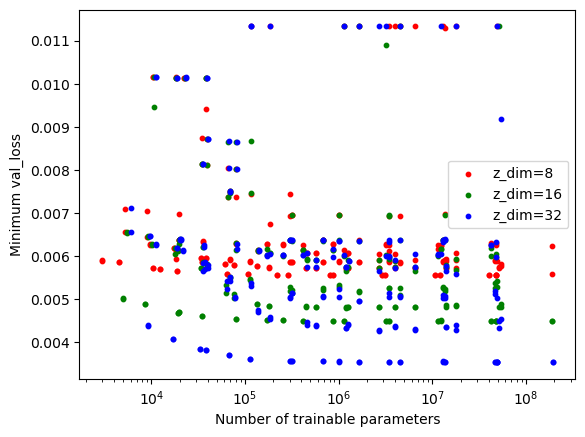

In [7]:
#plot the loss-size relation
os.chdir('/home/s/S.Liu/grf_lab')
b1=np.array(b)
plt.scatter(b1[[i for i, d in enumerate(h) if d.get('z_dim') == 8],2],b1[[i for i, d in enumerate(h) if d.get('z_dim') == 8],1],c='r',s=10,label='z_dim=8')
plt.scatter(b1[[i for i, d in enumerate(h) if d.get('z_dim') == 16],2],b1[[i for i, d in enumerate(h) if d.get('z_dim') == 16],1],c='g',s=10,label='z_dim=16')
plt.scatter(b1[[i for i, d in enumerate(h) if d.get('z_dim') == 32],2],b1[[i for i, d in enumerate(h) if d.get('z_dim') == 32],1],c='b',s=10,label='z_dim=32')
plt.xlabel('Number of trainable parameters')
plt.ylabel('Minimum val_loss')
plt.xscale('log')
plt.legend()
plt.savefig(f'lab-report/data_and_images/scan_Minimum_val_loss_Number_of_trainable_parameters.png')

In [ ]:
#save all the hyperparameter setting and corresponding results as .csv
def merge_as_dataframe(dict_list, list_of_lists, list_keys):
    """
    Merge each dictionary in dict_list with its corresponding list of values from list_of_lists.
    Convert the merged dictionaries to a pandas DataFrame and save it to a CSV file.
    
    Parameters:
    - dict_list: A list of dictionaries.
    - list_of_lists: A list of lists containing values to be merged with the dictionaries.
    - list_keys: A list of keys to be used for the lists.
    """
    merged_dicts = []
    
    # Iterate over the dictionaries and corresponding lists
    for d, lst in zip(dict_list, list_of_lists):
        # Convert the list to a dictionary using the provided keys
        list_dict = {key: value for key, value in zip(list_keys, lst)}
        # Merge the two dictionaries
        merged_dict = {**d, **list_dict}
        # Add the merged dictionary to the list
        merged_dicts.append(merged_dict)
    
    # Convert the list of merged dictionaries to a pandas DataFrame
    df = pd.DataFrame(merged_dicts)
    return df
    # df.to_csv(output_filename, index=False)
    # df = pd.read_csv(filename)
filename = 'lab-report/data_and_images/Auto2_scan.csv'
df=merge_as_dataframe(h, b, ['train_loss', 'minimum_val_loss', 'number_of_model_parameters'])
df.to_csv(filename)
df = pd.read_csv(filename)
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.max_rows', None)   
pd.set_option('display.max_columns', None)

In [8]:
filename = 'lab-report/data_and_images/Auto2_scan.csv'
df = pd.read_csv(filename)
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.max_rows', None)   
pd.set_option('display.max_columns', None)

In [8]:
df[df['z_dim']==8].sort_values(by='minimum_val_loss')
# 324	[16, 32, 64]	8	[]	0.0001	0.005565	0.005579	63945

,Unnamed: 0,knum,z_dim,Dsize,lr,train_loss,minimum_val_loss,number_of_model_parameters
0,0,"[512, 1024, 2048]",8,[],0.0001,0.005414,0.005548,47757321
24,24,"[512, 1024, 2048]",8,[],0.0001,0.005426,0.005548,47757321
288,288,"[256, 512, 1024]",8,[],0.0001,0.005441,0.005548,12082185
25,25,"[512, 1024, 2048]",8,[],0.0010,0.005426,0.005549,47757321
181,181,"[256, 512]",8,[],0.0010,0.005396,0.005550,2921993
432,432,"[128, 256, 512]",8,[],0.0001,0.005422,0.005551,3091977
180,180,"[256, 512]",8,[],0.0001,0.005409,0.005551,2921993
577,577,"[1024, 2048]",8,[],0.0010,0.005393,0.005551,39999497
433,433,"[128, 256, 512]",8,[],0.0010,0.005440,0.005551,3091977
552,552,"[512, 1024]",8,[],0.0001,0.005411,0.005552,10562569


In [9]:
df[df['z_dim']==16].sort_values(by='minimum_val_loss')
# 327	327	[16, 32, 64]	16	[]	0.0010	0.004573	0.004523	80337

,Unnamed: 0,knum,z_dim,Dsize,lr,train_loss,minimum_val_loss,number_of_model_parameters
290,290,"[256, 512, 1024]",16,[],0.0001,0.004364,0.004472,12344337
26,26,"[512, 1024, 2048]",16,[],0.0001,0.004357,0.004472,48281617
434,434,"[128, 256, 512]",16,[],0.0001,0.004378,0.004473,3223057
579,579,"[1024, 2048]",16,[],0.0010,0.004328,0.004473,42096657
146,146,"[128, 256]",16,[],0.0001,0.004348,0.004476,1133329
554,554,"[512, 1024]",16,[],0.0001,0.004343,0.004476,11611153
182,182,"[256, 512]",16,[],0.0001,0.004344,0.004476,3446289
183,183,"[256, 512]",16,[],0.0010,0.004342,0.004477,3446289
555,555,"[512, 1024]",16,[],0.0010,0.004333,0.004477,11611153
147,147,"[128, 256]",16,[],0.0010,0.004351,0.004477,1133329


In [10]:
df[df['z_dim']==32].sort_values(by='minimum_val_loss')
# 364	[32, 64, 128]	32	[]	0.0001	0.003561	0.003559	318369

,Unnamed: 0,knum,z_dim,Dsize,lr,train_loss,minimum_val_loss,number_of_model_parameters
35,35,"[1024, 2048, 4096]",32,[],0.0010,0.003384,0.003518,193032225
28,28,"[512, 1024, 2048]",32,[],0.0001,0.003387,0.003521,49330209
4,4,"[512, 1024, 2048]",32,[],0.0001,0.003390,0.003521,49330209
292,292,"[256, 512, 1024]",32,[],0.0001,0.003402,0.003523,12868641
436,436,"[128, 256, 512]",32,[],0.0001,0.003426,0.003527,3485217
437,437,"[128, 256, 512]",32,[],0.0010,0.003427,0.003527,3485217
34,34,"[1024, 2048, 4096]",32,[],0.0001,0.003393,0.003529,193032225
581,581,"[1024, 2048]",32,[],0.0010,0.003356,0.003531,46290977
556,556,"[512, 1024]",32,[],0.0001,0.003359,0.003531,13708321
184,184,"[256, 512]",32,[],0.0001,0.003362,0.003532,4494881


In [ ]:
htop20